# Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

In [2]:
pickle_path = ('../raw_data/clean-75-precinct.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

# Train & Test Df

## Add 6h date

In [3]:
def round_six_hours(period):
    
    if period.hour < 6:
        period = period.replace(hour = 0)
        
    elif period.hour < 12 :
        period = period.replace(hour = 6)
        
    elif period.hour < 18 :
        period = period.replace(hour = 12)
        
    else:
        period = period.replace(hour = 18)
        
    return period

df['six_hour_date'] = df['period'].apply(lambda x: round_six_hours(x))

## Split dataframe

In [4]:
df.shape

(208915, 21)

In [5]:
year = df['period'].apply(lambda x: int(x.strftime('%Y')))

In [6]:
year.nunique() * 0.7 # choosing X_train size

9.1

In [7]:
inf_train = df['period'] >= datetime(2007, 1, 1, 0, 0, 0)

sup_train = df['period'] < datetime(2016, 1, 1, 0, 0, 0)

train_df = df[inf_train & sup_train]

In [8]:
inf_test = df['period'] >= datetime(2016, 1, 1, 0, 0, 0)

sup_test = df['period'] <= datetime(2019, 10, 28, 0, 0, 0)

test_df = df[inf_test & sup_test]

In [9]:
train_df.shape, test_df.shape

((149669, 21), (56972, 21))

In [10]:
test_df.shape[0] / df.shape[0]

0.27270420984610966

# Matrix

In [11]:
def from_meters_to_steps(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth’s radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    return latO, lonO

In [45]:
def from_coord_to_matrix_six(df, lat_meters, lon_meters):
        """
        outputs the 3D matrix of all coordinates for a given bucket height and width in meters
        """
        
        lat_meters = lat_meters
        lon_meters = lon_meters
        
        df = df.copy()
        
        #add 'time_index' column to df
        #ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
        #df['time_index'] = df['period'].map(ind)
        ind = {time: index for index, time in enumerate(np.sort(df['six_hour_date'].unique()))}
        df['time_index'] = df['six_hour_date'].map(ind)
        
        grid_offset = np.array([ -df['latitude'].max() , df['longitude'].min(), 0 ]) # Where do you start
        
        #from meters to lat/lon step
        lat_spacing, lon_spacing = from_meters_to_steps(lat_meters, lon_meters )
        
        grid_spacing = np.array([lat_spacing , lon_spacing, 1 ]) # What's the space you consider (euclidian here)
        
        #get points coordinates
        coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                       in zip(df['latitude'],df['longitude'],df['time_index'])])

        # Convert point to index
        indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
        X = indexes[:,0]
        Y = indexes[:,1]
        Z = indexes[:,2]

        # virgin matrix
        # dim 1: distance of precinct in lat / lat_spacing
        a = np.zeros((np.round(0.1979377630000414 / lat_spacing).astype('int'),
                     np.round(0.48138366199999894 / lon_spacing).astype('int'),
                     Z.max() + 1))
    
        a[X, Y, Z] = 1

        lat_size = a.shape[1]
        lon_size = a.shape[2]
        img3D_non_conv = a

        return img3D_non_conv

In [52]:
img_six = from_coord_to_matrix_six(train_df, 50, 50)

In [53]:
def img_plot(img):
    
    fig, axes = plt.subplots(1, 4, figsize = (20, 10))

    max_lum = img.max()

    for i in range(4):
        axes[i].imshow(img[:, :, i], cmap = 'gray', vmin = 0, vmax = max_lum)

In [54]:
img_six.shape

(441, 821, 13127)

In [55]:
img_six_sample = img_six[:, :, 0:10]

In [18]:
img_six_sample.shape

(1443, 2267, 10)

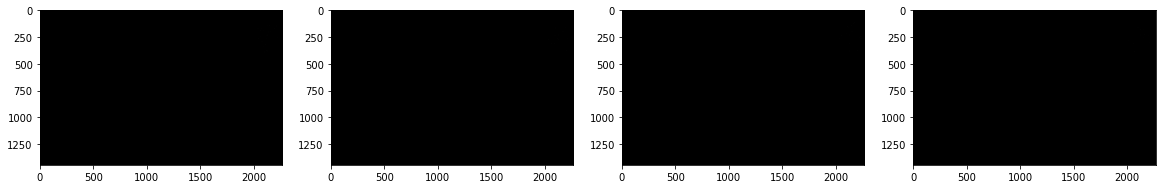

In [19]:
img_plot(img_six_sample)